# 🏦 ETL Project: Analysis of the Largest Banks in the World

## 📘 Introduction

In today's financial world, data on the largest banks plays a crucial role for both investors and researchers. A bank’s market capitalization reflects its scale, stability, and significance in the global arena. However, such data may be presented in a fragmented form and require processing to extract valuable insights.

This project aims to create an **automated ETL process** (Extract – Transform – Load) that retrieves, processes, and stores information on the largest global banks using publicly available sources.

---

## 🎯 Project Goals

- Extract up-to-date data on the largest banks by market capitalization  
- Convert market capitalization into different currencies (GBP, EUR, INR)  
- Save results in convenient formats (CSV, SQLite)  
- Work with ETL, web scraping, SQL, and logging in practice  
- Perform basic analysis and visualization of the obtained data

---

## 🗂️ Data Sources

-  **Wikipedia (archived):**  
  [List of largest banks](https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks)  
  Used to obtain the initial table with bank capitalization data (in USD).

-  **Exchange rate file:**  
  [exchange_rate.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-PY0221EN-Coursera/labs/v2/exchange_rate.csv)  
  Contains currency exchange rates needed to convert USD to GBP, EUR, and INR.

---

## 💡 Practical Significance

- Demonstrates building a **reproducible ETL process** using real-world data  
- Provides hands-on practice in web scraping, working with CSV and SQLite, writing SQL queries, and implementing logging  
- Forms a complete understanding of the data pipeline from extraction to analysis  
- Serves as a foundation for future projects

---

## 🔧 Code Structure

1. **Importing libraries**  
   Load necessary modules: `requests`, `BeautifulSoup`, `pandas`, `sqlite3` etc.

2. **Function definitions**  
   - `log_progress(message)` — logs execution steps  
   - `extract(url, table_attribs)` — extracts the table from Wikipedia  
   - `transform(df, csv_path)` — transforms the data and converts currencies  
   - `load_to_csv(df, output_path)` — saves the final data to a CSV file  
   - `load_to_db(df, sql_connection, table_name)` — loads the data into SQLite  
   - `run_query(query, sql_connection)` — runs SQL queries  

3. **Main execution block**  
   Executes the ETL process: defines variables, calls functions, logs progress, and outputs results  

4. **Final analysis and visualization**  
   Builds charts and provides a short summary of the results (comparing banks by market capitalization)  

---

### Let’s Begin the Implementation

Below starts the practical part of the project.  
Here we will implement the entire process step-by-step: from setting up the environment to building the complete ETL pipeline and performing the final analysis with visualizations.

The first step is to prepare the working environment: install and import the required libraries, and load the source data.


## 🧰 Step 1. Preliminary Information: Installing Libraries and Loading Data

Before starting the work, it is necessary to install and import all the required libraries.

### Libraries Used:

- `requests` — for downloading an HTML page from a URL  
- `BeautifulSoup` (from `bs4`) — for parsing HTML (web scraping)  
- `pandas` — for processing tables, storing data, and exporting results  
- `sqlite3` — for working with a SQLite database  
- `numpy` — for mathematical operations, including rounding  
- `datetime` — for working with dates and time (logging)  
- `matplotlib` — for visualizing the analysis results  


In [2]:
# Installing libraries (if not already installed)
%pip install requests beautifulsoup4 pandas numpy matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
# === Importing required libraries ===

import pandas as pd                    # For working with tables and CSV files
import numpy as np                     # For mathematical operations (e.g., rounding)
import requests                        # For downloading HTML pages from a website
from bs4 import BeautifulSoup          # For parsing HTML and web scraping tables
import sqlite3                         # For working with SQLite databases
from datetime import datetime          # For logging with timestamps
import matplotlib.pyplot as plt        # For data visualization


## 📄 Step 2. Project Parameters Initialization

At this stage, we define the main variables that will be used in the ETL process:

- `url` — archived link to the Wikipedia article containing the table of the world’s largest banks  
- `table_attribs` — list of column names to be used in the resulting DataFrame  
- `exchange_rate_path` — path to the CSV file with exchange rates for the transformation stage  
- `csv_path` — path for saving the final table in CSV format  
- `db_name` and `table_name` — name of the SQLite database and the table where the data will be stored  
- `log_path` — path to the file where logging events will be recorded


In [4]:
# === Set project parameters ===

#  Data source (web scraping)
url = 'https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks'       # Source of the table
table_attribs = ["Name", "MC_USD_Billion"]              # Columns to extract: Bank Name and Market Capitalization (in billions USD)

#  Paths to auxiliary files
exchange_rate_path = 'data/exchange_rate.csv'           # Path to the CSV file with currency exchange rates
log_path = './output/code_log.txt'                      # Path to the log file

#  Output paths
csv_path = './output/Largest_banks_data.csv'            # Path to the output CSV file
db_name = 'Banks.db'                                    # SQLite database name
table_name = 'Largest_banks'                            # Table name in the database


## 📝 Step 3: Logging Function `log_progress()`

To track the progress of the project, we create a log file named `code_log.txt`.

The `log_progress()` function will record key events (stages of the ETL pipeline) in this file.  
Each log entry will follow the format:


🔹 **timestamp** — the current date and time in the format `YYYY-MM-DD HH:MM:SS`  
🔹 **message** — a description of the current stage or event (for example, "Data extraction completed")

The log will be updated automatically when key functions are called, such as `extract()`, `transform()`, `load_to_csv()`, etc.

This is useful both for **debugging** and for **execution auditing**, especially in real-world projects.


In [5]:
def log_progress(message):
    '''
    This function writes the given message to the log file
    using the current timestamp. It is used to track
    the stages of the ETL process execution.
    '''

    timestamp_format = '%Y-%b-%d-%H:%M:%S'                # Timestamp format: Year-Month-Day-Hour-Minute-Second
    now = datetime.now()                                  # Get the current date and time
    timestamp = now.strftime(timestamp_format)            # Convert timestamp to the required string format

    with open(log_path, "a") as f:                        # Open the log file in append mode
        f.write(timestamp + ' : ' + message + '\n')       # Write in the format: <time> : <message>


## 🌐 Step 4: Data Extraction

In this step, we perform **web scraping** of a table from a Wikipedia page containing the list of the largest banks in the world by market capitalization.

Source:  
🔗 [https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks](https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks)


### Task:

- Send an HTTP request and retrieve the HTML content of the page  
- Locate the table containing the bank data  
- Convert the table into a `pandas.DataFrame`  
- Extract only the required columns:  
  - **Name** — the bank name  
  - **MC_USD_Billion** — market capitalization in billions of USD  


### Note:

Before writing the function, the **HTML code of the page was inspected using a browser**.

- The table has the class: `wikitable sortable`  
- Structure: `table > thead > tbody > tr > td`  
- The bank name is located in the second cell (`td[1]`), and the market capitalization is in the third cell (`td[2]`)


### 🖼️ HTML Table Structure (browser inspection)

The image below shows the actual table from Wikipedia and the corresponding HTML code.  
This helped identify the exact table — `<table class="wikitable sortable">`

![HTML-table](./images/html_table_inspect.png)

> 💡 From the table, we can see that the data is located inside `<tbody>` and follows a fixed structure:  
> `Rank | Bank name | Market cap (US$ billion)`


### 📄 Example HTML snippet (using `table.prettify()`):

```html
<table class="wikitable sortable mw-collapsible">
  <thead>
    <tr>
      <th>Rank</th>
      <th>Bank name</th>
      <th>Market cap (US$ billion)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10</td>
      <td><a href="...">Bank of China</a></td>
      <td>136.81</td>
    </tr>
    ...
  </tbody>
</table>
```

In [6]:
def extract(url, table_attribs):
    """
    Extracts a table of the largest banks from a Wikipedia page.
    
    Parameters:
    - url: link to the (archived) Wikipedia page
    - table_attribs: list of column names for the resulting DataFrame

    Returns:
    - df: DataFrame with two columns — Name and MC_USD_Billion
    """
    
    page = requests.get(url).text                              # Load the HTML content of the page from the given URL
    data = BeautifulSoup(page, 'html.parser')                  # Parse the HTML using the 'html.parser'
    
    df = pd.DataFrame(columns=table_attribs)                   # Create an empty DataFrame with the given columns
    
    tables = data.find_all('tbody')                            # Find all <tbody> elements — tables are usually inside them
    rows = tables[0].find_all('tr')                            # Extract rows from the first table (assuming it's the one we need)
    
    for row in rows:
        col = row.find_all('td')                               # Find all table cells (<td>) in the row
        if len(col) != 0:                                      # Skip rows without data (e.g., header rows)
            data_dict = {
                "Name": col[1].get_text(strip=True),           # Bank name — in the 2nd column
                "MC_USD_Billion": col[2].get_text(strip=True)  # Market cap — in the 3rd column
            }
            df1 = pd.DataFrame(data_dict, index=[0])           # Convert the dictionary to a DataFrame row
            df = pd.concat([df, df1], ignore_index=True)       # Append the row to the main DataFrame
    
    return df                                                  # Return the final DataFrame


#### 📄 Result after running `extract()`

After executing the `extract()` function, a table with two columns is generated:

- `Name` — bank name  
- `MC_USD_Billion` — market capitalization in billions of USD  

👇 Below is a snippet of the result:

- The table shows the world's largest banks, sorted by market capitalization.  
- The data was obtained via web scraping from Wikipedia.

![extract() result](./images/extract_output_result.png)


### 🔄 Step 5: Data Transformation

After extracting the table with banks’ market capitalizations, the next step is to convert the values from US dollars (USD) into other currencies — **British pounds (GBP)**, **euros (EUR)**, and **Indian rupees (INR)**.

#### At this stage:
- The `exchange_rate.csv` file containing current exchange rates is loaded.
- The rates are converted into a dictionary.
- Three new columns are added to the DataFrame:
  - `MC_GBP_Billion`
  - `MC_EUR_Billion`
  - `MC_INR_Billion`
- All values are rounded to two decimal places for better readability.

> 📌 This step illustrates the **Transformation** stage in the ETL process: data is not only loaded but also prepared for further use.


In [14]:
def transform(df, exchange_rate_path):
    """
    Reads currency exchange rates from a CSV file,
    converts the MC_USD_Billion column into other currencies,
    and adds new columns with the converted values.
    """
    
    # Read the exchange rates file and create a dictionary: {'GBP': 0.8, 'EUR': 0.93, 'INR': 82.95}
    exchange_df = pd.read_csv(exchange_rate_path)                        # Load CSV with exchange rates
    exchange_rate = exchange_df.set_index('Currency').to_dict()['Rate']  # Convert to dict {currency: rate}

    # Convert the market capitalization column to float
    df['MC_USD_Billion'] = df['MC_USD_Billion'].astype(float)

    # Add a column with capitalization in GBP
    df['MC_GBP_Billion'] = [np.round(x * exchange_rate['GBP'], 2) for x in df['MC_USD_Billion']]

    # Add a column with capitalization in EUR
    df['MC_EUR_Billion'] = [np.round(x * exchange_rate['EUR'], 2) for x in df['MC_USD_Billion']]

    # 🇮🇳 Add a column with capitalization in Indian rupees (INR)
    df['MC_INR_Billion'] = [np.round(x * exchange_rate['INR'], 2) for x in df['MC_USD_Billion']]

    return df            # Return the updated DataFrame


#### 📄 Result after running `transform()`

After applying the `transform()` function, the table is extended with three new columns:

- `MC_GBP_Billion` — market capitalization in **British pounds (GBP)**
- `MC_EUR_Billion` — market capitalization in **euros (EUR)**
- `MC_INR_Billion` — market capitalization in **Indian rupees (INR)**

👇 Below is a fragment of the result:

- All values are rounded to two decimal places
- Conversion is performed using the rates specified in the `exchange_rate.csv` file

![transform result](./images/transform_result.png)


## 💾 Step 6: Loading transformed data into CSV

After completing the transformation stage, the processed DataFrame needs to be saved into a CSV file. This allows you to:
 - Store data in a convenient tabular format
 - Use it for reporting, visualization, or further processing
 - Share it with other systems and applications

For this, the `load_to_csv()` function is implemented, which:
 - Takes the final DataFrame and a save path as inputs
 - Saves the data into the `Largest_banks_data.csv` file
 - Adds a log entry indicating that the data has been successfully saved

📄 The CSV file includes:
 - Bank names (`Name`)
 - Market capitalization in USD (`MC_USD_Billion`)
 - Converted values in British pounds (`MC_GBP_Billion`), euros (`MC_EUR_Billion`), and Indian rupees (`MC_INR_Billion`)

> 📁 This step completes saving the data in CSV format and prepares it for the next step — loading into a database.


In [13]:
def load_to_csv(df, csv_path):
    ''' 
    Saves the final DataFrame to a CSV file at the specified path.
    No return value.
    '''
    df.to_csv(csv_path, index=False)        # Save the table to CSV without indexes


#### 📄 Result after executing `load_to_csv()`

After running the `load_to_csv()` function, the data is saved to the `Largest_banks_data.csv` file, located in the `output/` folder.

This file contains:  
- Bank name (`Name`)  
- Market capitalization in US dollars (`MC_USD_Billion`)  
- Converted values in:  
  - British pounds (`MC_GBP_Billion`)  
  - Euros (`MC_EUR_Billion`)  
  - Indian rupees (`MC_INR_Billion`)  

👇 Below is a snippet of the CSV file content read back via `pd.read_csv()`:

```
               Name  MC_USD_Billion  MC_GBP_Billion  MC_EUR_Billion  MC_INR_Billion
0    JPMorgan Chase          432.92          346.34          402.62        35910.71
1   Bank of America          231.52          185.22          215.31        19204.58
2     ICBC                   194.56          155.65          180.94        16138.75
3     HSBC                   160.68          128.54          149.43        13328.41
...
```

> At this stage, the data is successfully stored in a tabular format and is ready for further use.  
>  
> 📂 The file can be found at: `output/Largest_banks_data.csv`


## 📥 Stage 7: Loading Data into a SQLite Database

After saving the data to a CSV file, the next step is to load it into a **SQLite** database — this enables running SQL queries for analysis and data retrieval.

We store the data in the `Banks.db` database using Python’s built-in `sqlite3` library.

This is important because:  
- Data becomes available for SQL-based analysis  
- It can be integrated with other systems  
- It is easy to automate queries, filtering, and reporting  

> At this stage, we implement the next element of the **ETL process** — _Load to storage_.


In [16]:
def load_to_db(df, sql_connection, table_name):
    ''' 
    This function saves the final DataFrame into a database table 
    with the specified name. No value is returned.
    '''
    # Save the DataFrame into the database table (overwrite if exists, exclude index)
    df.to_sql(table_name, sql_connection, if_exists='replace', index=False)


#### 📄 Result of `load_to_db()` Execution

After executing the `load_to_db()` function, the processed data table is saved into the **Banks.db** database.  
Below is the result of an SQL query to the database obtained using `pd.read_sql()`:

![Result of load_to_db() execution](./images/load_to_bd_result.png)

> At this stage, the data has been successfully loaded into the database and is ready for SQL processing.  
> 📁 The file can be found at: `Banks.db`


## ✅ Step 8. Executing SQL Queries

After loading the table into the database, we can run SQL queries to retrieve analytical information.

For this, we create a universal `run_query` function that:
- accepts an SQL query string and a database connection  
- executes the query  
- returns the result as a table


In [11]:
def run_query(query_statement, sql_connection):
    """ 
    Executes an SQL query on the database table and displays the result.
    No return value.
    """
    print(f"Running query: {query_statement}")               # Show the query being executed
    output = pd.read_sql(query_statement, sql_connection)    # Run the query and get a DataFrame
    display(output)                                            # Display the result nicely in Jupyter


🔽 Below is an example of using this function for demonstration purposes.  
The full block of SQL queries with ETL process logging will be presented in **Stage 9**.

![run_query() execution result](./images/run_query_result.png)


## ✅ Stage 9. Log Verification

Now that each key stage of the ETL process uses calls to `log_progress()` (extraction, transformation, loading, and SQL query execution), we need to ensure that the `code_log.txt` log has correctly recorded all steps. This makes it possible to track the execution flow and confirm the pipeline's reliability.


In [17]:
#  Logging the start of the ETL process
log_progress('Preliminaries complete. Initiating ETL process')

#  Step 1: Data Extraction (Extract)
df = extract(url, table_attribs)
log_progress('Data extraction complete. Initiating Transformation process')

#  Step 2: Data Transformation (Transform)
df = transform(df, exchange_rate_path)
log_progress('Data transformation complete. Initiating loading process')

#  Step 3: Saving data to CSV
load_to_csv(df, csv_path)
log_progress('Data saved to CSV file')

#  Step 4: Connecting to SQLite database
sql_connection = sqlite3.connect('Banks.db')
log_progress('SQL Connection initiated.')

#  Step 5: Loading data into the database (Load)
load_to_db(df, sql_connection, table_name)
log_progress('Data loaded to Database as a table, Executing queries')

#  Step 6: Executing SQL queries
# 1. Display the entire table
query_statement = "SELECT * FROM Largest_banks"
run_query(query_statement, sql_connection)

# 2. Calculate the average market capitalization in GBP
query_statement = "SELECT AVG(MC_GBP_Billion) FROM Largest_banks"
run_query(query_statement, sql_connection)

# 3. Retrieve the first 5 bank names
query_statement = "SELECT Name FROM Largest_banks LIMIT 5"
run_query(query_statement, sql_connection)

#  Step 7: Process completion
log_progress('Process Complete.')

#  Closing the database connection
sql_connection.close()
log_progress('Server Connection closed.')


Running query: SELECT * FROM Largest_banks


,Name,MC_USD_Billion,MC_GBP_Billion,MC_EUR_Billion,MC_INR_Billion
0,JPMorgan Chase,432.92,346.34,402.62,35910.71
1,Bank of America,231.52,185.22,215.31,19204.58
2,Industrial and Commercial Bank of China,194.56,155.65,180.94,16138.75
3,Agricultural Bank of China,160.68,128.54,149.43,13328.41
4,HDFC Bank,157.91,126.33,146.86,13098.63
5,Wells Fargo,155.87,124.70,144.96,12929.42
6,HSBC Holdings PLC,148.90,119.12,138.48,12351.26
7,Morgan Stanley,140.83,112.66,130.97,11681.85
8,China Construction Bank,139.82,111.86,130.03,11598.07
9,Bank of China,136.81,109.45,127.23,11348.39


Running query: SELECT AVG(MC_GBP_Billion) FROM Largest_banks


,AVG(MC_GBP_Billion)
0,151.987


Running query: SELECT Name FROM Largest_banks LIMIT 5


,Name
0,JPMorgan Chase
1,Bank of America
2,Industrial and Commercial Bank of China
3,Agricultural Bank of China
4,HDFC Bank


> Thus, the `code_log.txt` file ***records the entire ETL process flow*** —
from data extraction and transformation to the execution of SQL queries.
This confirms the correctness and reproducibility of each stage.



---

### RESULT  
The project covers all key stages of an ETL pipeline — from extracting data from a web page to loading it into a database and performing analytical SQL queries.

What has been done:

✅ Applied **web scraping techniques** to automatically collect information from websites  
✅ Worked with **Pandas DataFrames and dictionaries** to transform and enrich data  
✅ Saved data into **CSV files** and loaded them into an **SQLite database**  
✅ Executed **SQL queries** on tables directly from Python  
✅ Maintained an **ETL process log** in a text file  

---


After successfully completing all stages of the ETL process — extracting data from the website, converting currency values, saving to CSV and the database, and executing SQL queries — we have obtained a clean and structured dataset on the world’s largest banks.

Now that the data is prepared and available in a convenient format, we can move on to the next logical step — ***visual analysis***. This will not only help to better understand the structure of the obtained information but also reveal key patterns in the distribution of the banks’ market capitalization.

## 📊 Step 10. Mini Data Analysis and Visualization

After successfully completing the ETL process, the next step is to analyze and visualize the data obtained **directly from the database**.  
This ensures that the table has been loaded correctly and allows us to extract key insights.

As part of the analysis, we will select the **TOP-5 largest banks** by market capitalization in US dollars (USD) and also display their capitalization in euros (EUR) and British pounds (GBP).

Although market capitalization in Indian rupees (INR) was calculated during the transformation stage, it is **not included in the final charts and tables** because:
- its absolute values are significantly higher than those of other currencies (due to the exchange rate),
- Indian banks did not make it into the **TOP-5** by USD capitalization,
- visual comparison would be misleading.

---

📈 Next, using Python, we will run an SQL query on the database, retrieve the table, and plot a chart based on three currencies: **USD, EUR, and GBP**.


In [25]:
# Connect to the SQLite database and automatically close after use
with sqlite3.connect("Banks.db") as conn:
    print("Connected to database successfully.")
    
    # SQL query to select the TOP 5 banks by USD market capitalization
    query = """
    SELECT Name, MC_USD_Billion, MC_GBP_Billion, MC_EUR_Billion
    FROM Largest_banks
    ORDER BY MC_USD_Billion DESC
    LIMIT 5
    """
    
    # Load the result into a DataFrame
    top5_simple = pd.read_sql(query, conn)
    print("Query executed successfully.")

# Save to CSV
top5_simple.to_csv("output/top5_banks.csv", index=False)
print("Data saved to output/top5_banks.csv")

# Display a styled DataFrame in Jupyter
top5_simple.style.background_gradient(cmap='YlGnBu')

Connected to database successfully.
Query executed successfully.
Data saved to output/top5_banks.csv


,Name,MC_USD_Billion,MC_GBP_Billion,MC_EUR_Billion
0,JPMorgan Chase,432.920000,346.340000,402.620000
1,Bank of America,231.520000,185.220000,215.310000
2,Industrial and Commercial Bank of China,194.560000,155.650000,180.940000
3,Agricultural Bank of China,160.680000,128.540000,149.430000
4,HDFC Bank,157.910000,126.330000,146.860000


We will build a horizontal bar chart titled ***"Market Capitalization in USD, EUR, and GBP (Top 5 Banks)"***, showing the market capitalization of the world’s top five largest banks.

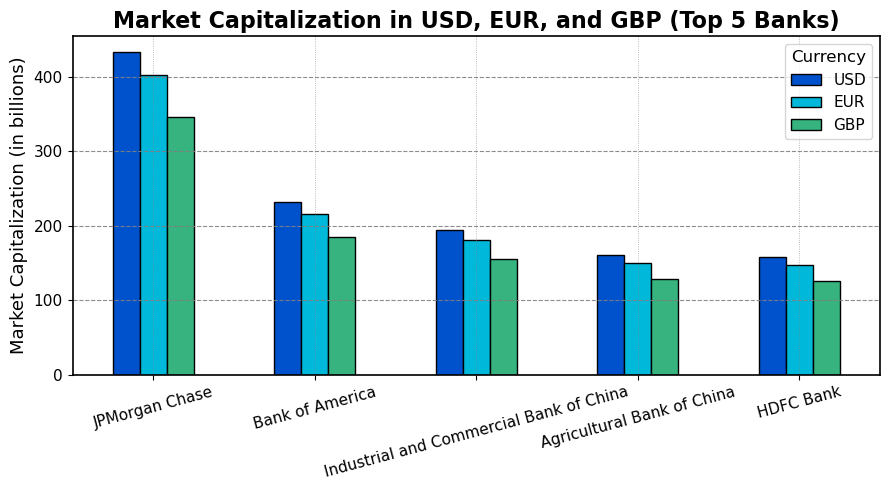

In [21]:
# Color palette for the three currencies:
colors = ['#0052cc', '#00b8d9', '#36B37E']  

#  Create a Figure and Axes object with a white background
fig, ax = plt.subplots(figsize=(9, 5), facecolor='white')  
ax.set_facecolor('white')                                   # set the background color of the plotting area

#  Building the bar chart:
#  Plot a bar chart with specified colors and black borders
top5_simple.set_index("Name")[["MC_USD_Billion", "MC_EUR_Billion", "MC_GBP_Billion"]].plot(
    kind='bar',                # chart type — vertical bars
    ax=ax,                     # axis to plot on
    color=colors,              # colors of the bars
    edgecolor='black',         # color of the bar borders
    linewidth=1                # border thickness
)

#  Title and axis labels
ax.set_title("Market Capitalization in USD, EUR, and GBP (Top 5 Banks)", 
             fontsize=16, fontweight='bold', color='black')                 # chart title
ax.set_ylabel("Market Capitalization (in billions)", fontsize=13, color='black')  # Y-axis label
ax.set_xlabel("")                                                           # remove X-axis label (banks are on tick labels)
ax.tick_params(axis='x', labelrotation=15, labelsize=11, colors='black')    # format X-axis ticks
ax.tick_params(axis='y', labelsize=11, colors='black')                      # format Y-axis ticks

#  Grid for better readability
ax.grid(axis='y', linestyle='--', color='gray', linewidth=0.8, alpha=0.9)   # horizontal grid
ax.grid(axis='x', linestyle=':', color='gray', linewidth=0.6, alpha=0.7)    # vertical grid

#  Frame styling (chart borders)
for spine in ax.spines.values():
    spine.set_edgecolor('black')                                            # black border
    spine.set_linewidth(1.2)                                                # border thickness

#  Legend with the title "Currency"
ax.legend(["USD", "EUR", "GBP"], title="Currency", title_fontsize=12, fontsize=11)

#  Save the chart as an SVG file (high quality, scalable)
plt.tight_layout()                                                          # optimize spacing
plt.savefig("images/top5_banks_market_cap.svg", dpi=300, bbox_inches='tight')

#  Display the chart
plt.show()


## Key Observations

When comparing market capitalization in **USD**, **EUR**, and **GBP**, the **gap between the first bank (JPMorgan Chase)** and the rest of the list is particularly striking:

- The largest bank by market capitalization is **JPMorgan Chase** — over **$430 billion**.
- The top 5 mostly include **American** and **Chinese** banks, highlighting the dominance of the **U.S. and Chinese** economies in the global banking sector.
- **European** and **Indian** banks are represented much less frequently — typically holding only **1–2 positions** in the rankings.
- When comparing market capitalization across **three currencies**, we observe:
  - A significant lead of the top bank (**JPMorgan Chase**) over others;
  - A gradual decrease in capitalization from 1st to 5th place;
  - Preservation of proportions between banks when converted to EUR and GBP, indicating the **stability of their relative positions**.

---

## ✅ Project Conclusions

The project successfully demonstrated all key stages of the **ETL process**, concluding with the analytical phase and data visualization.

The results allow us to draw the following conclusions:

- **JPMorgan Chase** confidently leads in market capitalization in all currencies considered.
- The **global banking sector** is oriented toward the U.S. and China — their banks hold the leading positions.
- Currency conversion does not affect the ranking order of market capitalization, highlighting the **stability and predictability** of the top banks.

---
